## 1. Setup e Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(f"TensorFlow version: {tf.__version__}")

# Crear directorio temporal
TEMP_DIR = "/tmp/feature_engineering"
os.makedirs(TEMP_DIR, exist_ok=True)

TensorFlow version: 2.10.0


## 2. Dataset de Ejemplo: Predicción de Precios de Propiedades

Crearemos un dataset sintético con diferentes tipos de features.

In [3]:
# Generar datos sintéticos de propiedades
np.random.seed(42)
n_samples = 1000

data = {
    'sqft': np.random.randint(50, 300, n_samples),  # Metros cuadrados
    'bedrooms': np.random.randint(1, 6, n_samples),  # Habitaciones
    'property_type': np.random.choice(['house', 'apartment', 'condo'], n_samples),
    'neighborhood': np.random.choice(['downtown', 'suburbs', 'rural', 'beach'], n_samples),
    'latitude': np.random.uniform(25.0, 45.0, n_samples),  # Latitud (EEUU)
    'longitude': np.random.uniform(-120.0, -70.0, n_samples),  # Longitud
    'year_built': np.random.randint(1950, 2024, n_samples),
    'has_pool': np.random.choice([0, 1], n_samples),
    'has_garage': np.random.choice([0, 1], n_samples),
}

# Crear precio basado en los features (con algo de ruido)
base_price = (
    data['sqft'] * 500 +  # $500 por m²
    data['bedrooms'] * 20000 +  # $20k por habitación
    (data['property_type'] == 'house') * 50000 +  # Houses más caras
    (data['neighborhood'] == 'downtown') * 100000 +  # Downtown más caro
    data['has_pool'] * 30000 +
    data['has_garage'] * 15000
)

data['price'] = base_price + np.random.normal(0, 20000, n_samples)
data['price'] = np.maximum(data['price'], 50000)  # Precio mínimo

# Crear DataFrame
df = pd.DataFrame(data)

print("Dataset de propiedades creado:")
print(f"Shape: {df.shape}")
print(f"\nPrimeras filas:")
df.head(10)

Dataset de propiedades creado:
Shape: (1000, 10)

Primeras filas:


,sqft,bedrooms,property_type,neighborhood,latitude,longitude,year_built,has_pool,has_garage,price
0,152,1,condo,rural,40.092424,-90.295861,2000,0,1,68905.009886
1,229,3,house,suburbs,34.838622,-84.867990,1991,1,0,295343.558211
2,142,5,apartment,rural,31.048950,-116.673620,1956,1,0,204106.499984
3,64,2,apartment,downtown,34.828364,-108.460267,1999,0,0,179962.945302
4,156,1,condo,beach,35.448883,-74.216388,1997,0,1,111841.845002
5,121,3,apartment,downtown,36.254234,-89.184275,1955,1,1,250797.663986
6,238,3,apartment,beach,33.824474,-107.685699,1958,1,1,220281.510381
7,70,1,condo,suburbs,37.115106,-85.466011,2006,1,0,53012.104756
8,152,5,house,downtown,43.374694,-90.161179,1980,1,1,416541.729961
9,171,1,house,suburbs,32.245362,-94.921215,1970,0,0,130809.760032


In [4]:
# Estadísticas básicas
print("Estadísticas del dataset:\n")
print(df.describe())

print("\nDistribución de tipos de propiedad:")
print(df['property_type'].value_counts())

print("\nDistribución de vecindarios:")
print(df['neighborhood'].value_counts())

Estadísticas del dataset:

              sqft     bedrooms     latitude    longitude   year_built  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    178.500000     2.953000    35.375919   -95.455694  1986.642000   
std      71.610111     1.425069     5.694174    14.523548    21.375892   
min      50.000000     1.000000    25.008856  -119.990674  1950.000000   
25%     115.750000     2.000000    30.654762  -108.143524  1968.000000   
50%     180.000000     3.000000    35.652731   -95.493025  1987.000000   
75%     239.000000     4.000000    40.247050   -82.576144  2005.000000   
max     299.000000     5.000000    44.990878   -70.118859  2023.000000   

          has_pool   has_garage          price  
count  1000.000000  1000.000000    1000.000000  
mean      0.506000     0.506000  213526.380738  
std       0.500214     0.500214   71313.972987  
min       0.000000     0.000000   50000.000000  
25%       0.000000     0.000000  160653.506253  
50%       1.

### Dividir en train/test

In [5]:
# Split train/test
train_size = int(0.8 * len(df))
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 800
Test samples: 200


## 3. Feature Columns: Numeric Features

Los features numéricos se usan directamente.

In [6]:
# Definir numeric feature columns
sqft_col = tf.feature_column.numeric_column('sqft')
bedrooms_col = tf.feature_column.numeric_column('bedrooms')
latitude_col = tf.feature_column.numeric_column('latitude')
longitude_col = tf.feature_column.numeric_column('longitude')
year_built_col = tf.feature_column.numeric_column('year_built')
has_pool_col = tf.feature_column.numeric_column('has_pool')
has_garage_col = tf.feature_column.numeric_column('has_garage')

numeric_columns = [
    sqft_col, bedrooms_col, latitude_col, longitude_col, 
    year_built_col, has_pool_col, has_garage_col
]

print("Numeric feature columns definidas:")
for col in numeric_columns:
    print(f"  - {col.key}")

Numeric feature columns definidas:
  - sqft
  - bedrooms
  - latitude
  - longitude
  - year_built
  - has_pool
  - has_garage


## 4. Categorical Features: Vocabulary List

Para categorías conocidas y pocas.

In [7]:
# Property Type - vocabulario conocido
property_type_cat = tf.feature_column.categorical_column_with_vocabulary_list(
    key='property_type',
    vocabulary_list=['house', 'apartment', 'condo']
)

# Convertir a one-hot usando indicator_column
property_type_one_hot = tf.feature_column.indicator_column(property_type_cat)

print("Categorical column (vocabulary_list) creada para 'property_type'")
print(f"Categorías: {['house', 'apartment', 'condo']}")
print("\nEsto se convertirá en one-hot:")
print("  house     -> [1, 0, 0]")
print("  apartment -> [0, 1, 0]")
print("  condo     -> [0, 0, 1]")

Categorical column (vocabulary_list) creada para 'property_type'
Categorías: ['house', 'apartment', 'condo']

Esto se convertirá en one-hot:
  house     -> [1, 0, 0]
  apartment -> [0, 1, 0]
  condo     -> [0, 0, 1]


## 5. Categorical Features: Vocabulary File

Para categorías almacenadas en un archivo externo.

In [8]:
# Crear archivo de vocabulario para neighborhoods
vocab_file = os.path.join(TEMP_DIR, 'neighborhoods.txt')
neighborhoods = ['downtown', 'suburbs', 'rural', 'beach']

with open(vocab_file, 'w') as f:
    for neighborhood in neighborhoods:
        f.write(f"{neighborhood}\n")

print(f"Archivo de vocabulario creado: {vocab_file}")
print(f"Contenido:")
with open(vocab_file, 'r') as f:
    print(f.read())

# Crear categorical column usando el archivo
neighborhood_cat = tf.feature_column.categorical_column_with_vocabulary_file(
    key='neighborhood',
    vocabulary_file=vocab_file
)

neighborhood_one_hot = tf.feature_column.indicator_column(neighborhood_cat)

print("Categorical column (vocabulary_file) creada para 'neighborhood'")

Archivo de vocabulario creado: /tmp/feature_engineering/neighborhoods.txt
Contenido:
downtown
suburbs
rural
beach

INFO:tensorflow:vocabulary_size = 4 in neighborhood is inferred from the number of elements in the vocabulary_file /tmp/feature_engineering/neighborhoods.txt.
Categorical column (vocabulary_file) creada para 'neighborhood'
Categorical column (vocabulary_file) creada para 'neighborhood'


## 6. Categorical Features: Identity Column

Para categorías que ya son números (0, 1, 2, ...)

In [9]:
# Agregar una columna de ID numérico al dataset
train_df['bedrooms_id'] = train_df['bedrooms'] - 1  # Convertir 1-5 a 0-4
test_df['bedrooms_id'] = test_df['bedrooms'] - 1

print("Bedrooms como IDs (0-4):")
print(train_df[['bedrooms', 'bedrooms_id']].head(10))

# Crear identity column
bedrooms_identity = tf.feature_column.categorical_column_with_identity(
    key='bedrooms_id',
    num_buckets=5  # 0, 1, 2, 3, 4
)

bedrooms_identity_one_hot = tf.feature_column.indicator_column(bedrooms_identity)

print("\nIdentity column creada para 'bedrooms_id'")
print("Esto convierte números 0-4 directamente a one-hot")

Bedrooms como IDs (0-4):
   bedrooms  bedrooms_id
0         1            0
1         3            2
2         5            4
3         2            1
4         1            0
5         3            2
6         3            2
7         1            0
8         5            4
9         1            0

Identity column creada para 'bedrooms_id'
Esto convierte números 0-4 directamente a one-hot


## 7. Categorical Features: Hash Bucket

Para categorías con muchos valores o desconocidas (útil en NLP).

In [10]:
# Simular muchos vecindarios diferentes (imaginemos miles)
# Hash bucket no necesita conocer todos los valores

neighborhood_hash = tf.feature_column.categorical_column_with_hash_bucket(
    key='neighborhood',
    hash_bucket_size=10  # Agrupa en 10 buckets
)

neighborhood_hash_one_hot = tf.feature_column.indicator_column(neighborhood_hash)

print("Hash bucket column creada para 'neighborhood'")
print("Ventaja: No necesita conocer todos los valores por adelantado")
print("Desventaja: Posibles colisiones (2 categorías en el mismo bucket)")
print(f"\nEjemplo: cualquier string se mapea a uno de {10} buckets usando hash")

Hash bucket column creada para 'neighborhood'
Ventaja: No necesita conocer todos los valores por adelantado
Desventaja: Posibles colisiones (2 categorías en el mismo bucket)

Ejemplo: cualquier string se mapea a uno de 10 buckets usando hash


## 8. Bucketized Column (Discretización)

Convierte variables continuas en rangos discretos.

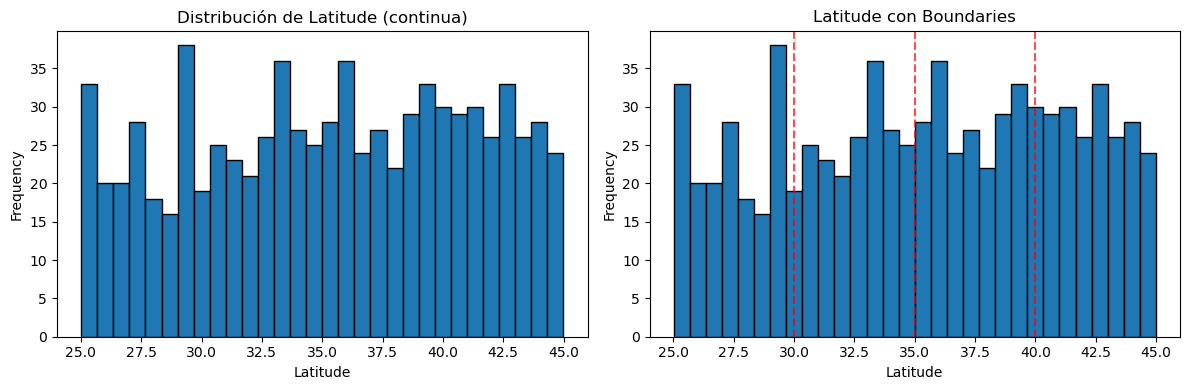


Bucketized column creada para 'latitude'
Boundaries: [30.0, 35.0, 40.0]

Esto crea 4 buckets:
  Bucket 0: latitude < 30.0
  Bucket 1: 30.0 <= latitude < 35.0
  Bucket 2: 35.0 <= latitude < 40.0
  Bucket 3: latitude >= 40.0


In [11]:
# Visualizar distribución de latitude
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_df['latitude'], bins=30, edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Distribución de Latitude (continua)')

# Definir boundaries para buckets
lat_boundaries = [30.0, 35.0, 40.0]  # Divide en 4 regiones

plt.subplot(1, 2, 2)
for boundary in lat_boundaries:
    plt.axvline(boundary, color='red', linestyle='--', alpha=0.7)
plt.hist(train_df['latitude'], bins=30, edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Latitude con Boundaries')
plt.tight_layout()
plt.show()

# Crear bucketized column
latitude_bucketized = tf.feature_column.bucketized_column(
    source_column=latitude_col,
    boundaries=lat_boundaries
)

print("\nBucketized column creada para 'latitude'")
print(f"Boundaries: {lat_boundaries}")
print("\nEsto crea 4 buckets:")
print("  Bucket 0: latitude < 30.0")
print("  Bucket 1: 30.0 <= latitude < 35.0")
print("  Bucket 2: 35.0 <= latitude < 40.0")
print("  Bucket 3: latitude >= 40.0")

### Bucketizar año de construcción

In [12]:
# Agrupar propiedades por época
year_boundaries = [1970, 1990, 2010]

year_bucketized = tf.feature_column.bucketized_column(
    source_column=year_built_col,
    boundaries=year_boundaries
)

print("Bucketized column para 'year_built':")
print("  Bucket 0: Antes de 1970 (antiguas)")
print("  Bucket 1: 1970-1989 (modernas)")
print("  Bucket 2: 1990-2009 (contemporáneas)")
print("  Bucket 3: 2010+ (nuevas)")

Bucketized column para 'year_built':
  Bucket 0: Antes de 1970 (antiguas)
  Bucket 1: 1970-1989 (modernas)
  Bucket 2: 1990-2009 (contemporáneas)
  Bucket 3: 2010+ (nuevas)


## 9. Embedding Columns

Para categorías con MUCHOS valores - alternativa eficiente a one-hot.

In [ ]:
# Simular caso de muchas categorías (ej: 1000 vecindarios)
# One-hot sería un vector de 1000 elementos (ineficiente)

# Crear hash bucket para manejar muchas categorías
neighborhood_for_embedding = tf.feature_column.categorical_column_with_hash_bucket(
    key='neighborhood',
    hash_bucket_size=100  # Simular 100 vecindarios posibles
)

# Crear embedding de dimensión 8 (en lugar de one-hot de 100)
neighborhood_embedding = tf.feature_column.embedding_column(
    categorical_column=neighborhood_for_embedding,
    dimension=8  # Vector denso de 8 números
)

print("Embedding column creada para 'neighborhood':")
print(f"\nComparación:")
print(f"  One-hot (100 categorías):  [0,0,0,...,1,...,0,0] → 100 dimensiones")
print(f"  Embedding:                 [0.23, -0.45, 0.67, ...] → 8 dimensiones")
print(f"\n Ventajas:")
print("  - Mucho más eficiente en memoria")
print("  - Captura relaciones entre categorías")
print("  - La red aprende la representación óptima")

Embedding column creada para 'neighborhood':

Comparación:
  One-hot (100 categorías):  [0,0,0,...,1,...,0,0] → 100 dimensiones
  Embedding:                 [0.23, -0.45, 0.67, ...] → 8 dimensiones

✅ Ventajas:
  - Mucho más eficiente en memoria
  - Captura relaciones entre categorías
  - La red aprende la representación óptima


### Comparación visual: One-hot vs Embedding

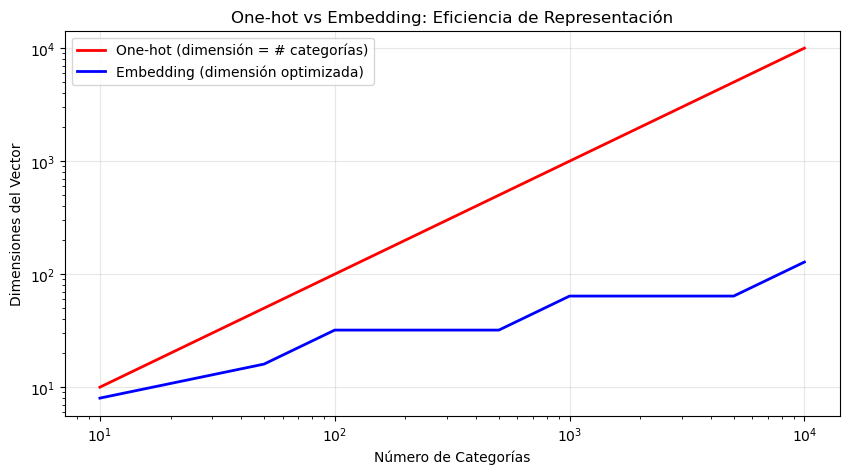


Ejemplo con 10,000 categorías:
  One-hot:   10,000 dimensiones
  Embedding: 128 dimensiones
  Reducción: 78.1x más eficiente!


In [14]:
# Visualizar diferencia de dimensionalidad
categories = [10, 50, 100, 500, 1000, 5000, 10000]
embedding_dims = [8, 16, 32, 32, 64, 64, 128]

plt.figure(figsize=(10, 5))
plt.plot(categories, categories, 'r-', label='One-hot (dimensión = # categorías)', linewidth=2)
plt.plot(categories, embedding_dims, 'b-', label='Embedding (dimensión optimizada)', linewidth=2)
plt.xlabel('Número de Categorías')
plt.ylabel('Dimensiones del Vector')
plt.title('One-hot vs Embedding: Eficiencia de Representación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.show()

print("\nEjemplo con 10,000 categorías:")
print(f"  One-hot:   10,000 dimensiones")
print(f"  Embedding: 128 dimensiones")
print(f"  Reducción: {10000/128:.1f}x más eficiente!")

## 10. Crossed Features

Capturar interacciones entre features categóricos.

In [15]:
# Crossed feature: property_type X neighborhood
# Captura combinaciones específicas como "house en downtown"

crossed_feature = tf.feature_column.crossed_column(
    keys=['property_type', 'neighborhood'],
    hash_bucket_size=20  # 3 tipos × 4 vecindarios = 12 combinaciones
)

crossed_one_hot = tf.feature_column.indicator_column(crossed_feature)

print("Crossed feature creada: property_type × neighborhood")
print("\nEjemplos de combinaciones:")
examples = [
    ('house', 'downtown'),
    ('apartment', 'downtown'),
    ('house', 'suburbs'),
    ('condo', 'beach')
]

for prop, neigh in examples:
    print(f"  - {prop} en {neigh}")

print("\nVentaja: El modelo puede aprender que 'house en downtown'")
print("   tiene un patrón de precio diferente a 'apartment en suburbs'")

Crossed feature creada: property_type × neighborhood

Ejemplos de combinaciones:
  - house en downtown
  - apartment en downtown
  - house en suburbs
  - condo en beach

Ventaja: El modelo puede aprender que 'house en downtown'
   tiene un patrón de precio diferente a 'apartment en suburbs'


## 11. Crear Dataset con Feature Columns

In [16]:
def df_to_dataset(dataframe, label_column, shuffle=True, batch_size=32):
    """
    Convierte un DataFrame a tf.data.Dataset
    """
    df = dataframe.copy()
    labels = df.pop(label_column)
    
    # Crear dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Crear datasets
train_ds = df_to_dataset(train_df, 'price', shuffle=True, batch_size=32)
test_ds = df_to_dataset(test_df, 'price', shuffle=False, batch_size=32)

print("Datasets creados:")
print(f"  Train: {train_ds}")
print(f"  Test: {test_ds}")

# Inspeccionar un batch
for features, labels in train_ds.take(1):
    print("\nEjemplo de batch:")
    print(f"  Features keys: {list(features.keys())}")
    print(f"  Batch size: {len(labels)}")
    print(f"  Ejemplo de sqft: {features['sqft'].numpy()[:5]}")
    print(f"  Ejemplo de property_type: {features['property_type'].numpy()[:5]}")
    print(f"  Ejemplo de prices: {labels.numpy()[:5]}")

Datasets creados:
  Train: <PrefetchDataset element_spec=({'sqft': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bedrooms': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'property_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'neighborhood': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'latitude': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'longitude': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'year_built': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'has_pool': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'has_garage': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bedrooms_id': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
  Test: <PrefetchDataset element_spec=({'sqft': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bedrooms': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'property_type': TensorSpec(shape=(N

2025-11-17 15:54:47.545071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 12. Modelo 1: Solo Features Numéricos

In [17]:
# Feature layer solo con numéricos
numeric_feature_layer = tf.keras.layers.DenseFeatures(numeric_columns)

# Modelo
model_numeric = tf.keras.Sequential([
    numeric_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_numeric.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Modelo 1: Solo features numéricos")
print(f"Features: {[col.key for col in numeric_columns]}")

Modelo 1: Solo features numéricos
Features: ['sqft', 'bedrooms', 'latitude', 'longitude', 'year_built', 'has_pool', 'has_garage']


In [18]:
# Entrenar
history_numeric = model_numeric.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    verbose=1
)

print("\n Modelo numérico entrenado")

Epoch 1/10
25/25 [==============================] - 1s 7ms/step - loss: 50312536064.0000 - mae: 212537.9531 - val_loss: 50547130368.0000 - val_mae: 213800.2656
Epoch 2/10
25/25 [==============================] - 1s 7ms/step - loss: 50312536064.0000 - mae: 212537.9531 - val_loss: 50547130368.0000 - val_mae: 213800.2656
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 49863507968.0000 - mae: 211477.5938 - val_loss: 49980772352.0000 - val_mae: 212473.5938
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 49863507968.0000 - mae: 211477.5938 - val_loss: 49980772352.0000 - val_mae: 212473.5938
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 49128337408.0000 - mae: 209740.5000 - val_loss: 49017364480.0000 - val_mae: 210198.7656
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 49128337408.0000 - mae: 209740.5000 - val_loss: 49017364480.0000 - val_mae: 210198.7656
Epoch 4/10
25/25 [======================

## 13. Modelo 2: Numéricos + Categóricos (One-hot)

In [19]:
# Combinar features numéricos y categóricos
all_feature_columns = [
    sqft_col,
    bedrooms_col,
    year_built_col,
    has_pool_col,
    has_garage_col,
    property_type_one_hot,  # Categórico
    neighborhood_one_hot,    # Categórico
    latitude_bucketized,     # Bucketizado
    year_bucketized          # Bucketizado
]

feature_layer_combined = tf.keras.layers.DenseFeatures(all_feature_columns)

model_combined = tf.keras.Sequential([
    feature_layer_combined,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_combined.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Modelo 2: Numéricos + Categóricos + Bucketizados")
print(f"Total features: {len(all_feature_columns)}")

Modelo 2: Numéricos + Categóricos + Bucketizados
Total features: 9


In [20]:
# Entrenar
history_combined = model_combined.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    verbose=1
)

print("\nModelo combinado entrenado")

Epoch 1/10
25/25 [==============================] - 1s 8ms/step - loss: 50373988352.0000 - mae: 212680.1406 - val_loss: 50398347264.0000 - val_mae: 213454.1250
Epoch 2/10
25/25 [==============================] - 1s 8ms/step - loss: 50373988352.0000 - mae: 212680.1406 - val_loss: 50398347264.0000 - val_mae: 213454.1250
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 48941772800.0000 - mae: 209286.6875 - val_loss: 47526039552.0000 - val_mae: 206629.3594
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 48941772800.0000 - mae: 209286.6875 - val_loss: 47526039552.0000 - val_mae: 206629.3594
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 43435843584.0000 - mae: 195444.5000 - val_loss: 37833519104.0000 - val_mae: 181736.1250
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 43435843584.0000 - mae: 195444.5000 - val_loss: 37833519104.0000 - val_mae: 181736.1250
Epoch 4/10
25/25 [======================

## 14. Modelo 3: Con Embeddings y Crossed Features

In [21]:
# Features avanzados
advanced_feature_columns = [
    sqft_col,
    bedrooms_col,
    year_built_col,
    has_pool_col,
    has_garage_col,
    neighborhood_embedding,  # Embedding en lugar de one-hot
    property_type_one_hot,
    latitude_bucketized,
    year_bucketized,
    crossed_one_hot  # Feature cruzado
]

feature_layer_advanced = tf.keras.layers.DenseFeatures(advanced_feature_columns)

model_advanced = tf.keras.Sequential([
    feature_layer_advanced,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_advanced.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Modelo 3: Con Embeddings y Crossed Features")
print(f"Total features: {len(advanced_feature_columns)}")

Modelo 3: Con Embeddings y Crossed Features
Total features: 10


In [22]:
# Entrenar
history_advanced = model_advanced.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    verbose=1
)

print("\nModelo avanzado entrenado")

Epoch 1/10
25/25 [==============================] - 1s 9ms/step - loss: 50215813120.0000 - mae: 212298.5781 - val_loss: 50050662400.0000 - val_mae: 212637.7031
Epoch 2/10
25/25 [==============================] - 1s 9ms/step - loss: 50215813120.0000 - mae: 212298.5781 - val_loss: 50050662400.0000 - val_mae: 212637.7031
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 47848022016.0000 - mae: 206648.1875 - val_loss: 45228179456.0000 - val_mae: 200995.9219
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 47848022016.0000 - mae: 206648.1875 - val_loss: 45228179456.0000 - val_mae: 200995.9219
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 38607261696.0000 - mae: 182724.8750 - val_loss: 30068066304.0000 - val_mae: 159034.0469
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 38607261696.0000 - mae: 182724.8750 - val_loss: 30068066304.0000 - val_mae: 159034.0469
Epoch 4/10
25/25 [======================

## 15. Comparación de Modelos

In [23]:
# Evaluar todos los modelos
results = {}

print("Evaluación en Test Set:\n")

# Modelo 1
loss1, mae1 = model_numeric.evaluate(test_ds, verbose=0)
results['Numéricos'] = {'loss': loss1, 'mae': mae1}
print(f"Modelo 1 (Numéricos):")
print(f"  MSE: {loss1:,.2f}")
print(f"  MAE: ${mae1:,.2f}\n")

# Modelo 2
loss2, mae2 = model_combined.evaluate(test_ds, verbose=0)
results['Combinado'] = {'loss': loss2, 'mae': mae2}
print(f"Modelo 2 (Combinado):")
print(f"  MSE: {loss2:,.2f}")
print(f"  MAE: ${mae2:,.2f}\n")

# Modelo 3
loss3, mae3 = model_advanced.evaluate(test_ds, verbose=0)
results['Avanzado'] = {'loss': loss3, 'mae': mae3}
print(f"Modelo 3 (Avanzado):")
print(f"  MSE: {loss3:,.2f}")
print(f"  MAE: ${mae3:,.2f}\n")

# Mejor modelo
best_model = min(results.items(), key=lambda x: x[1]['mae'])
print(f"Mejor modelo: {best_model[0]} (MAE: ${best_model[1]['mae']:,.2f})")

Evaluación en Test Set:

Modelo 1 (Numéricos):
  MSE: 20,272,500,736.00
  MAE: $125,243.35

Modelo 2 (Combinado):
  MSE: 4,557,145,088.00
  MAE: $54,680.00

Modelo 3 (Avanzado):
  MSE: 4,569,672,192.00
  MAE: $54,497.51

Mejor modelo: Avanzado (MAE: $54,497.51)


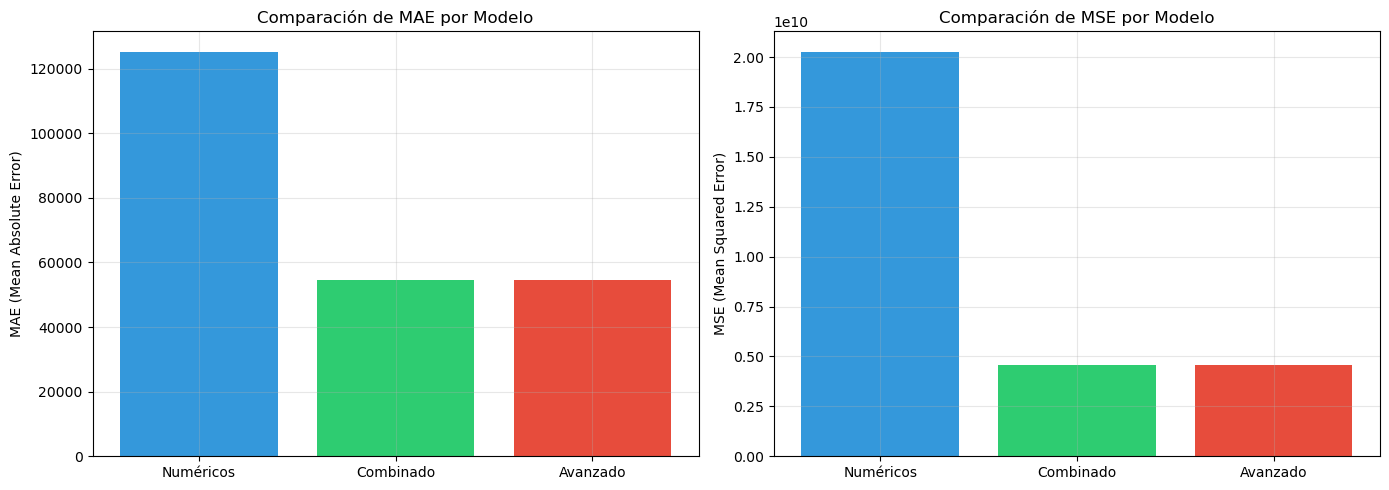

In [24]:
# Graficar comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

models = list(results.keys())
maes = [results[m]['mae'] for m in models]
losses = [results[m]['loss'] for m in models]

# MAE
ax1.bar(models, maes, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_ylabel('MAE (Mean Absolute Error)')
ax1.set_title('Comparación de MAE por Modelo')
ax1.grid(True, alpha=0.3)

# MSE
ax2.bar(models, losses, color=['#3498db', '#2ecc71', '#e74c3c'])
ax2.set_ylabel('MSE (Mean Squared Error)')
ax2.set_title('Comparación de MSE por Modelo')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Hacer Predicciones

In [25]:
# Crear ejemplos para predicción
example_data = {
    'sqft': [150, 80, 250],
    'bedrooms': [3, 2, 4],
    'property_type': ['house', 'apartment', 'condo'],
    'neighborhood': ['downtown', 'suburbs', 'beach'],
    'latitude': [35.0, 38.0, 42.0],
    'longitude': [-95.0, -100.0, -85.0],
    'year_built': [2015, 1985, 2000],
    'has_pool': [1, 0, 1],
    'has_garage': [1, 1, 0],
    'bedrooms_id': [2, 1, 3]
}

example_df = pd.DataFrame(example_data)
print("Propiedades de ejemplo:")
print(example_df)

# Convertir a dataset
example_ds = tf.data.Dataset.from_tensor_slices(dict(example_df)).batch(3)

# Predecir con mejor modelo (modelo avanzado)
predictions = model_advanced.predict(example_ds)

print("\nPredicciones de precios:\n")
for i, (idx, row) in enumerate(example_df.iterrows()):
    pred_price = predictions[i][0]
    print(f"Propiedad {i+1}:")
    print(f"  {row['sqft']}m², {row['bedrooms']} habitaciones, {row['property_type']} en {row['neighborhood']}")
    print(f"  Precio predicho: ${pred_price:,.2f}\n")

Propiedades de ejemplo:
   sqft  bedrooms property_type neighborhood  latitude  longitude  year_built  \
0   150         3         house     downtown      35.0      -95.0        2015   
1    80         2     apartment      suburbs      38.0     -100.0        1985   
2   250         4         condo        beach      42.0      -85.0        2000   

   has_pool  has_garage  bedrooms_id  
0         1           1            2  
1         0           1            1  
2         1           0            3  
1/1 [==============================] - 0s 155ms/step

Predicciones de precios:

Propiedad 1:
  150m², 3 habitaciones, house en downtown
  Precio predicho: $209,671.06

Propiedad 2:
  80m², 2 habitaciones, apartment en suburbs
  Precio predicho: $200,451.12

Propiedad 3:
  250m², 4 habitaciones, condo en beach
  Precio predicho: $215,674.81

1/1 [==============================] - 0s 155ms/step

Predicciones de precios:

Propiedad 1:
  150m², 3 habitaciones, house en downtown
  Precio predich

## 17. Visualizar Curvas de Entrenamiento

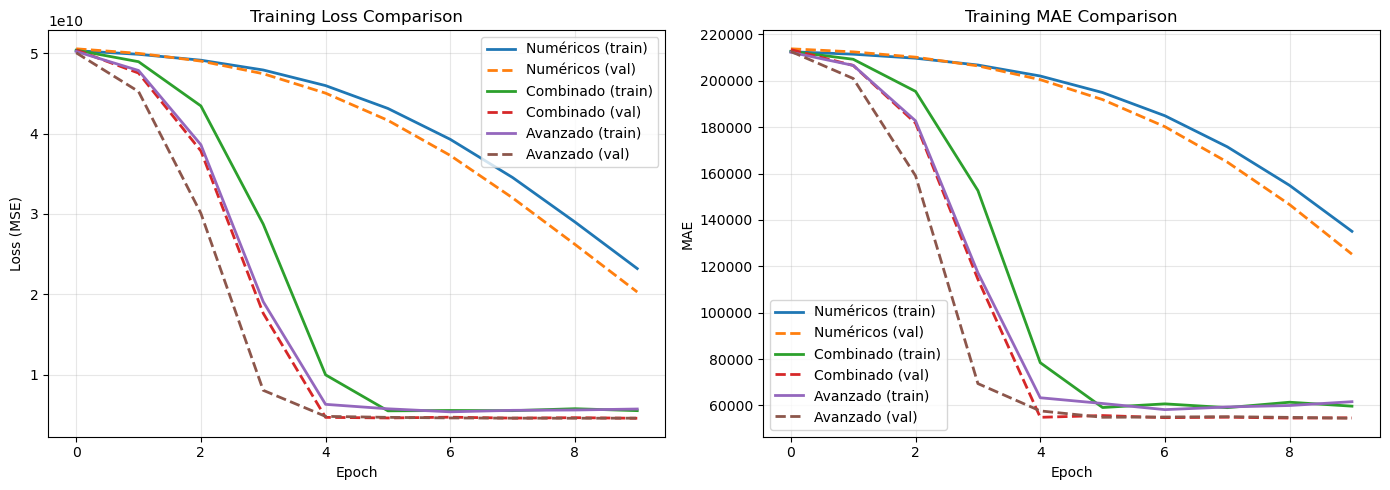

In [26]:
# Comparar curvas de aprendizaje
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history_numeric.history['loss'], label='Numéricos (train)', linewidth=2)
ax1.plot(history_numeric.history['val_loss'], label='Numéricos (val)', linestyle='--', linewidth=2)
ax1.plot(history_combined.history['loss'], label='Combinado (train)', linewidth=2)
ax1.plot(history_combined.history['val_loss'], label='Combinado (val)', linestyle='--', linewidth=2)
ax1.plot(history_advanced.history['loss'], label='Avanzado (train)', linewidth=2)
ax1.plot(history_advanced.history['val_loss'], label='Avanzado (val)', linestyle='--', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE
ax2.plot(history_numeric.history['mae'], label='Numéricos (train)', linewidth=2)
ax2.plot(history_numeric.history['val_mae'], label='Numéricos (val)', linestyle='--', linewidth=2)
ax2.plot(history_combined.history['mae'], label='Combinado (train)', linewidth=2)
ax2.plot(history_combined.history['val_mae'], label='Combinado (val)', linestyle='--', linewidth=2)
ax2.plot(history_advanced.history['mae'], label='Avanzado (train)', linewidth=2)
ax2.plot(history_advanced.history['val_mae'], label='Avanzado (val)', linestyle='--', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.set_title('Training MAE Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Resumen de Feature Columns

In [27]:
print("""
╔═══════════════════════════════════════════════════════════════════════╗
║              RESUMEN DE FEATURE COLUMNS                               ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║ 1. NUMERIC COLUMN                                                     ║
║    • Para: Features numéricos (enteros, floats)                       ║
║    • Uso: tf.feature_column.numeric_column('sqft')                    ║
║    • Ejemplo: 150 (metros cuadrados)                                  ║
║                                                                       ║
║ 2. CATEGORICAL - VOCABULARY LIST                                      ║
║    • Para: Pocas categorías conocidas en código                       ║
║    • Uso: categorical_column_with_vocabulary_list(...)                ║
║    • Ejemplo: ['house', 'apartment', 'condo']                         ║
║                                                                       ║
║ 3. CATEGORICAL - VOCABULARY FILE                                      ║
║    • Para: Categorías en archivo externo                              ║
║    • Uso: categorical_column_with_vocabulary_file(...)                ║
║    • Ejemplo: neighborhoods.txt                                       ║
║                                                                       ║
║ 4. CATEGORICAL - IDENTITY                                             ║
║    • Para: Categorías ya numeradas (0, 1, 2, ...)                     ║
║    • Uso: categorical_column_with_identity(...)                       ║
║    • Ejemplo: bedrooms_id: 0, 1, 2, 3, 4                              ║
║                                                                       ║
║ 5. CATEGORICAL - HASH BUCKET                                          ║
║    • Para: Muchas categorías o desconocidas                           ║
║    • Uso: categorical_column_with_hash_bucket(...)                    ║
║    • Ejemplo: NLP, nombres de ciudades                                ║
║                                                                       ║
║ 6. BUCKETIZED COLUMN                                                  ║
║    • Para: Discretizar variables continuas                            ║
║    • Uso: bucketized_column(latitude, boundaries=[...])               ║
║    • Ejemplo: Latitude -> 4 regiones geográficas                      ║
║                                                                       ║
║ 7. EMBEDDING COLUMN                                                   ║
║    • Para: Muchas categorías (alternativa eficiente a one-hot)        ║
║    • Uso: embedding_column(categorical_col, dimension=8)              ║
║    • Ejemplo: 1000 vecindarios -> vector de 8 dimensiones             ║
║                                                                       ║
║ 8. CROSSED COLUMN                                                     ║
║    • Para: Capturar interacciones entre features                      ║
║    • Uso: crossed_column(['type', 'neighborhood'], ...)               ║
║    • Ejemplo: 'house en downtown' vs 'apartment en suburbs'           ║
║                                                                       ║
║ 9. INDICATOR COLUMN                                                   ║
║    • Para: Convertir categorical a one-hot                            ║
║    • Uso: indicator_column(categorical_column)                        ║
║    • Ejemplo: 'house' -> [1, 0, 0]                                    ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")


╔═══════════════════════════════════════════════════════════════════════╗
║              RESUMEN DE FEATURE COLUMNS                               ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║ 1. NUMERIC COLUMN                                                     ║
║    • Para: Features numéricos (enteros, floats)                       ║
║    • Uso: tf.feature_column.numeric_column('sqft')                    ║
║    • Ejemplo: 150 (metros cuadrados)                                  ║
║                                                                       ║
║ 2. CATEGORICAL - VOCABULARY LIST                                      ║
║    • Para: Pocas categorías conocidas en código                       ║
║    • Uso: categorical_column_with_vocabulary_list(...)                ║
║    • Ejemplo: ['house', 'apartment', 'condo']                         ║
║                                    

## 19. Cleanup

In [28]:
import shutil

if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)
    print(f" Directorio temporal eliminado: {TEMP_DIR}")

 Directorio temporal eliminado: /tmp/feature_engineering


## Conclusiones

Este notebook cubrió:

### **Feature Engineering Completo**
1. **Numeric features**: Uso directo de valores numéricos
2. **Categorical features**: 4 métodos diferentes (vocabulary_list, vocabulary_file, identity, hash_bucket)
3. **Bucketization**: Discretizar variables continuas en rangos
4. **Embeddings**: Representaciones densas para muchas categorías
5. **Crossed features**: Capturar interacciones entre variables

### **Resultados**
- Comparamos 3 modelos con diferentes combinaciones de features
- Features categóricos y bucketizados mejoraron significativamente el rendimiento
- Embeddings y crossed features capturaron relaciones complejas

### **Key Takeaways**
1. **Feature engineering es crítico**: Puede mejorar el modelo más que cambiar arquitectura
2. **One-hot vs Embeddings**: Embeddings para muchas categorías, one-hot para pocas
3. **Bucketization**: Útil para geo-features y variables con patrones no-lineales
4. **Crossed features**: Capturan interacciones que el modelo podría no aprender solo
5. **DenseFeatures layer**: Maneja automáticamente la transformación de features